In [2]:
from astropy.io import fits
import astropy.coordinates as coord
import astropy.table as at
from astropy.time import Time
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

In [2]:
allstar = at.Table.read('/Users/apricewhelan/data/APOGEE_DR17/allStarLite-dr17-synspec_rev1.fits')

In [3]:
allvisit = at.Table.read('/Users/apricewhelan/data/APOGEE_DR17/allVisitLite-dr17-synspec.fits')

In [4]:
apid = '2M04123153+6738486'

In [5]:
star = allstar[allstar['APOGEE_ID'] == apid]
c = coord.SkyCoord(ra=star['RA']*u.deg, dec=star['DEC']*u.deg)[0]
star['LOGG', 'TEFF', 'FE_H', 'ALPHA_M']

LOGG,TEFF,FE_H,ALPHA_M
float32,float32,float32,float32
1.9763849,4214.5107,-0.81562,6.100163e-05


In [6]:
star['ASPCAPFLAGS']

"VMICRO_WARN,STAR_WARN,COLORTE_WARN"


In [7]:
f"https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr17/stars/{star['TELESCOPE'][0]}/{star['FIELD'][0]}"

'https://data.sdss.org/sas/apogeework/apogee/spectro/redux/dr17/stars/apo25m/140+12'

In [8]:
visits = allvisit[allvisit['APOGEE_ID'] == '2M04123153+6738486']
visits.sort('JD')
visits['JD', 'VHELIO']

JD,VHELIO
float64,float64
2457279.99438,-86.96878061638574
2457292.96813,-59.995043083621184
2457320.92338,-7.598405828513279
2457323.87005,-10.865378668762826


In [9]:
import pathlib
from urllib.request import urlopen
import requests
from tqdm import tqdm


def download_file(
    url, 
    local_path=None, 
    local_filename=None, 
    block_size=102400,
    overwrite=False
):
    if local_path is None:
        local_path = '.'
    local_path = pathlib.Path(local_path).resolve().absolute()
    
    if local_filename is None:
        local_filename = url.split('/')[(-1)]
    full_local_path = local_path / local_filename
    
    if full_local_path.exists() and not overwrite:
        return full_local_path
    
    site = urlopen(url)
    meta = site.info()
    total_size = int(meta['Content-Length'])
    
    response = requests.get(url, stream=True)
    progress_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
    with open(full_local_path, 'wb') as f:
        for data in response.iter_content(block_size):
            progress_bar.update(len(data))
            f.write(data)

    progress_bar.close()
    return full_local_path

In [10]:
apstar_url = (
    "https://data.sdss.org/sas/dr17/apogee/spectro/redux/dr17/stars/"
    + f"{star['TELESCOPE'][0]}/{star['FIELD'][0]}/"
    + f"apStar-dr17-{star['APOGEE_ID'][0]}.fits"
)
apstar_filename = download_file(apstar_url, local_path='.')

In [11]:
hdulist = fits.open(apstar_filename)
hdulist.info()

Filename: /Users/apricewhelan/projects/demo-notebooks/apStar-dr17-2M04123153+6738486.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     132   ()      
  1                1 ImageHDU        12   (8575, 6)   float64   
  2                1 ImageHDU        12   (8575, 6)   float64   
  3                1 ImageHDU        12   (8575, 6)   int64   
  4                1 ImageHDU        12   (8575, 6)   float64   
  5                1 ImageHDU        12   (8575, 6)   float64   
  6                1 ImageHDU        12   (8575, 6)   float64   
  7                1 ImageHDU        12   (8575, 6)   float64   
  8                1 ImageHDU         5   ()      
  9                1 BinTableHDU     58   4R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 765D, 765D, 765D, D, D, D, D, D, 765D]   
 10                1 BinTableHDU     58   1R x 23C   [72A, D, D, D, D, D, D, D, D, D, D, D, D, D, 243D, 243D, 243D, D, D, D, D, D, 243D]   


In [12]:
tbl = at.Table(hdulist[9].data)

In [13]:
tbl

filename,jd,snr,vhelio,vrel,vrelerr,teff,tefferr,logg,loggerr,feh,feherr,chisq,bc,x_ccf [765],ccf [765],ccferr [765],xcorr_vrel,xcorr_vrelerr,xcorr_vhelio,ccpfwhm,autofwhm,autoccf [765]
str72,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
apVisit-dr17-7922-57279-046.fits,2457279.99438,74.7478,-86.96878061638574,-107.602386573417,0.06204058774217788,4362.332696036238,3.0174579173146676,2.3321554443182917,0.011806146952801503,-0.9756698641023689,0.0038868132700503964,2.2031578981364666,20.63360595703125,-977.8462340458252 .. 1024.0078083662092,-0.005864797552276705 .. -0.012852128309419574,0.0022822117907300658 .. 0.002471091096350991,-107.602386573417,0.02513405405308365,-86.96878061638574,25.592257251194063,16.918181657696614,-0.02909154816879396 .. -0.033559348600402134
apVisit-dr17-7922-57292-040.fits,2457292.96813,155.479,-59.995043083621184,-79.68363027234189,0.0301190159952581,4362.332696036238,3.0174579173146676,2.3321554443182917,0.011806146952801503,-0.9756698641023689,0.0038868132700503964,4.090857340424349,19.688587188720703,-976.9584509007947 .. 1024.6416735915495,0.011799707122083858 .. -0.004314083411393083,0.0010142534972624702 .. 0.0010995049459477941,-79.68363027234189,0.14719783421321042,-59.995043083621184,24.945236819121213,17.09081353033643,0.01967294412541333 .. -0.02934781906605649
apVisit-dr17-7922-57320-046.fits,2457320.92338,105.726,-7.598405828513279,-21.9931707287208,0.044275485804403464,4362.332696036238,3.0174579173146676,2.3321554443182917,0.011806146952801503,-0.9756698641023689,0.0038868132700503964,2.940899011951017,14.39476490020752,-982.2306322522405 .. 1019.4334026610059,-0.006886492094107188 .. 0.011824914974722236,0.0016359393501770615 .. 0.001764998184855449,-21.9931707287208,0.07849379766203886,-7.598405828513279,25.523374619660757,16.92014014069161,-0.03455763764097411 .. -0.006639659644523606
apVisit-dr17-7922-57323-045.fits,2457323.87005,142.872,-10.865378668762826,-24.52862291619935,0.03384337458059673,4362.332696036238,3.0174579173146676,2.3321554443182917,0.011806146952801503,-0.9756698641023689,0.0038868132700503964,3.734677524629403,13.663244247436523,-982.8757002885275 .. 1018.7843690308803,-0.004385889481039828 .. 0.009832189684162473,0.0012045610105739036 .. 0.0012967652694603914,-24.52862291619935,0.07341839588142755,-10.865378668762826,24.88822628769926,17.350099139908743,-0.026766749087116636 .. -0.009420499991363959


Text(0.5, 0, '$\\Delta v$')

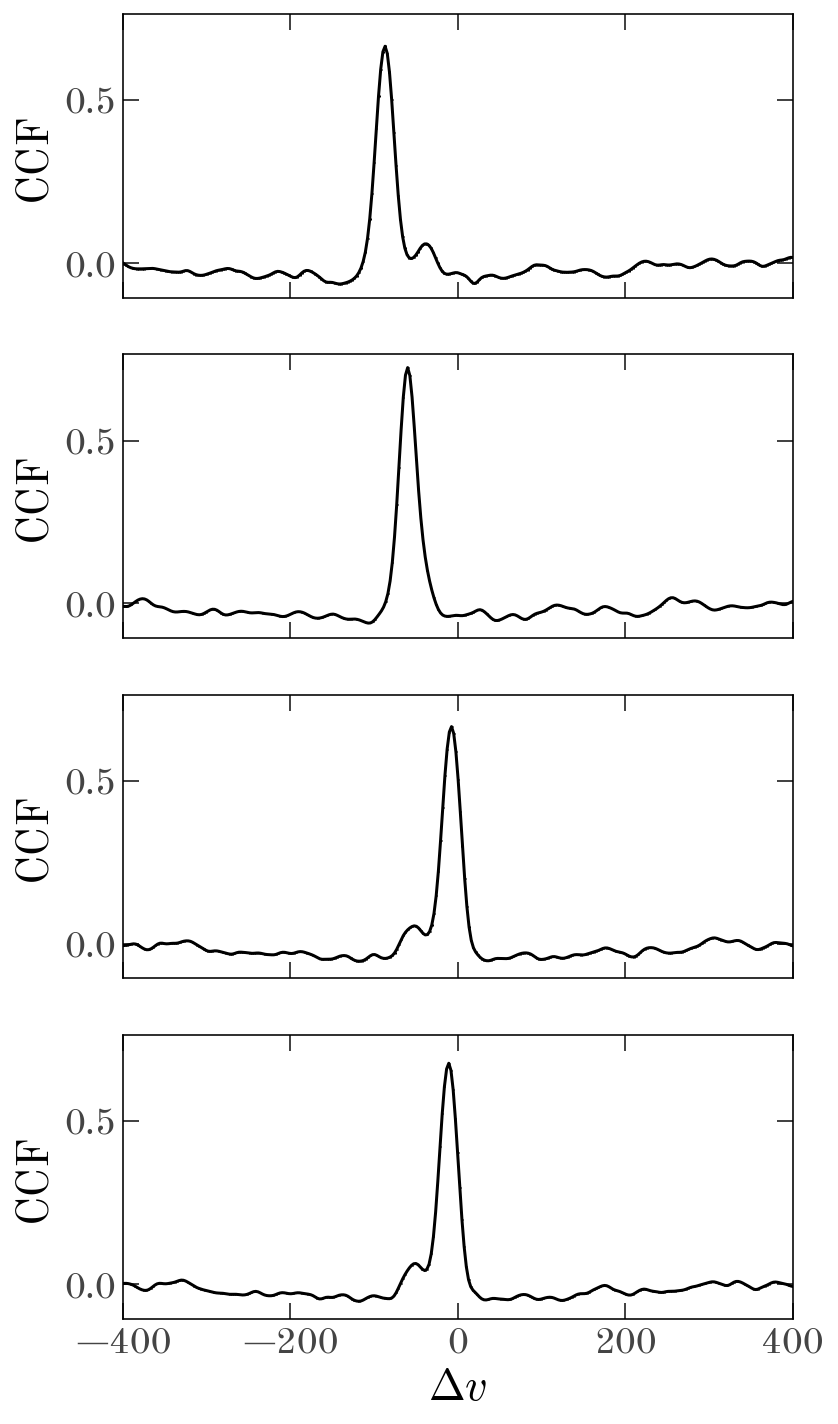

In [14]:
fig, axes = plt.subplots(
    len(tbl), 1, 
    figsize=(6, 3 * len(tbl)), 
    sharex=True, 
    sharey=True
)

for ax, row in zip(axes, tbl):
    ax.errorbar(row['x_ccf'], row['ccf'], row['ccferr'], marker='')
    ax.set_ylabel('CCF')
    
ax.set_xlim(-400, 400)
ax.set_xlabel(r'$\Delta v$')

In [15]:
def gaussian(p, x):
    A, x0, sigma = p
    return A / (np.sqrt(2*np.pi) * sigma) * np.exp(-0.5 * (x - x0)**2 / sigma**2)

def model(p, x):
    model_y1 = gaussian(p[:3], x)
    model_y2 = gaussian(p[3:6], x)
    model_y3 = np.poly1d(p[6:])(x)
    model_y = model_y1 + model_y2 + model_y3
    return model_y

def chisq(p, x, y, yerr):
    model_y = model(p, x)
    return np.sum((y - model_y)**2 / yerr**2)

def ln_likelihood(p, x, y, yerr):
    return -0.5 * chisq

In [16]:
from scipy.optimize import minimize
from scipy.signal import argrelmax

In [17]:
def get_data(row):
    x, y, yerr = row['x_ccf'], row['ccf'], row['ccferr']
    mask = (x > -400) & (x < 400)
    return x[mask], y[mask], yerr[mask]

In [18]:
fitted_pars = []
init_pars = []
for row in tbl:
    x, y, yerr = get_data(row)

    init = (0.5, x[y.argmax()], 10.,
            0.05, x[y.argmax()] + 20, 10.,
            4e-7, 0, -0.05)
    res = minimize(chisq, x0=init, args=(x, y, yerr), method='powell')
    print(res)
    fitted_pars.append(res.x)
    init_pars.append(init)

   direc: array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  1.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-7.97669467e-02, -2.82749981e-02, -5.39193685e-02,
         1.47223251e-01, -1.68821903e-01,  4.48496385e-01,
        -5.44786773e-09,  2.13960473e-09,  5.20183545e-04],
       [ 7.69100127e-01, -3.19464387e-03,  3.29349398e-02,
         4.55349847e-02,  1.15472717e+00, -1.21407548e-01,
        -1.94983252e-09,  1.60987307e-06,  3.35967788e-04],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,

In [19]:
visits

APOGEE_ID,TARGET_ID,FILE,FIBERID,PLATE,MJD,TELESCOPE,FIELD,SNR,STARFLAG,JD,VLSR,VGSR,VREL,VRELERR,VHELIO,BC,N_COMPONENTS,RV_COMPONENTS [3],RV_FLAG
bytes23,bytes23,bytes45,int16,bytes16,int32,bytes6,bytes19,float32,int64,float64,float32,float32,float64,float64,float64,float64,int32,float32,int32
2M04123153+6738486,2M04123153+6738486,apVisit-dr17-7922-57279-046.fits,46,7922,57279,apo25m,140+12,74.7478,0,2457279.99438,999999.0,999999.0,-107.602386573417,0.06204058774217788,-86.96878061638574,20.63360595703125,1,0.0 .. 0.0,0
2M04123153+6738486,2M04123153+6738486,apVisit-dr17-7922-57292-040.fits,40,7922,57292,apo25m,140+12,155.479,0,2457292.96813,999999.0,999999.0,-79.68363027234189,0.0301190159952581,-59.995043083621184,19.688587188720703,1,0.0 .. 0.0,0
2M04123153+6738486,2M04123153+6738486,apVisit-dr17-7922-57320-046.fits,46,7922,57320,apo25m,140+12,105.726,0,2457320.92338,999999.0,999999.0,-21.9931707287208,0.044275485804403464,-7.598405828513279,14.39476490020752,1,0.0 .. 0.0,0
2M04123153+6738486,2M04123153+6738486,apVisit-dr17-7922-57323-045.fits,45,7922,57323,apo25m,140+12,142.872,0,2457323.87005,999999.0,999999.0,-24.52862291619935,0.03384337458059673,-10.865378668762826,13.663244247436523,1,0.0 .. 0.0,0


-87.10814085207817 -39.59659237452311
-59.979060976974615 -36.86089247408638
-7.808734656787118 -52.292236883268835
-11.05857123908802 -51.89297404288302


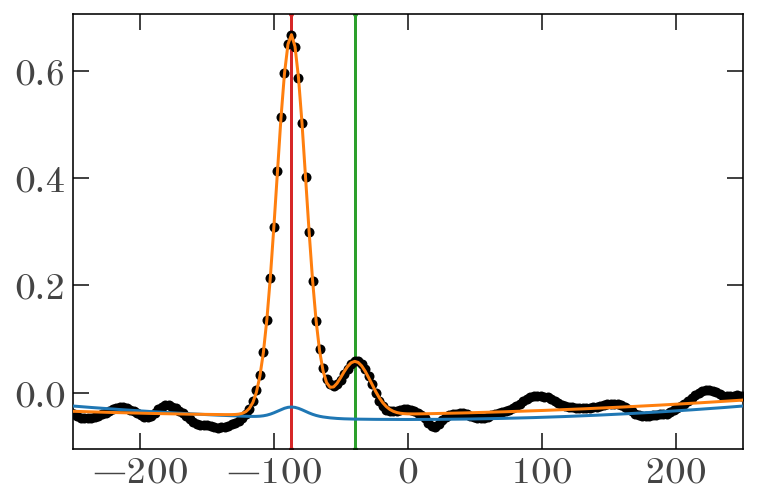

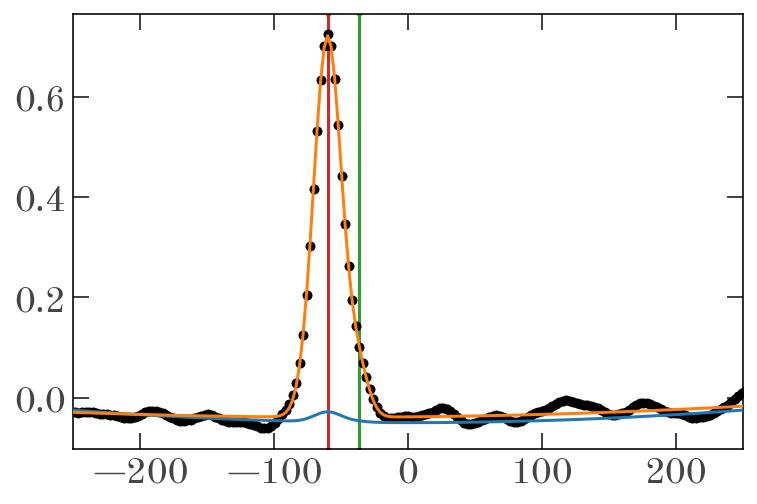

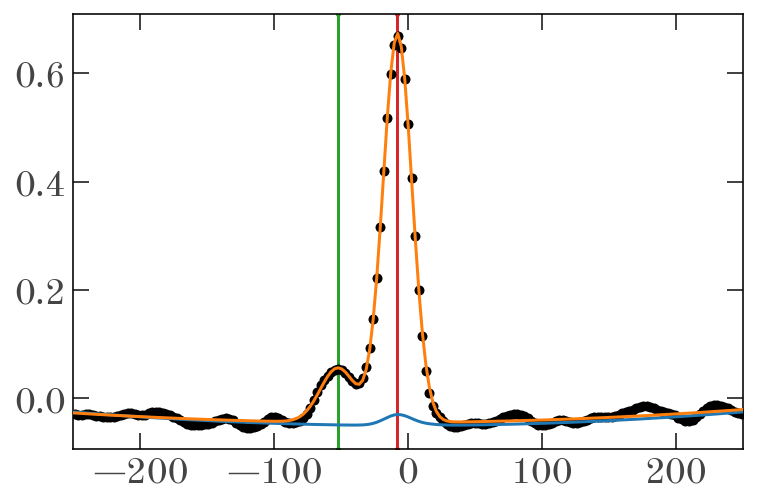

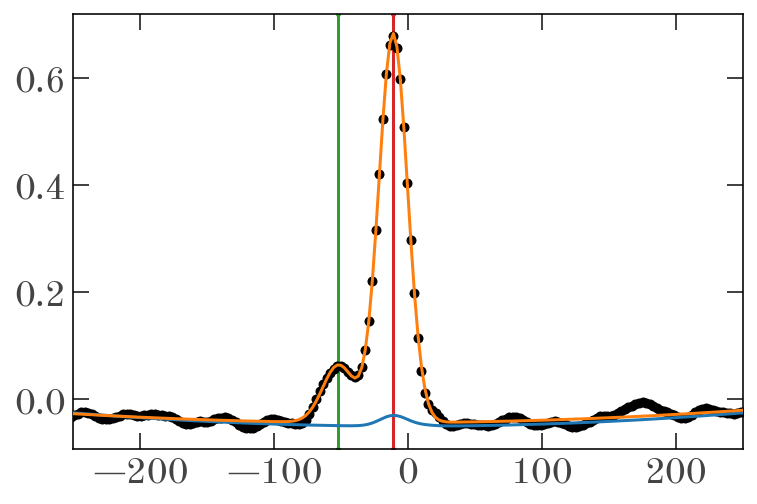

In [20]:
rv1s = []
rv2s = []
for row, fitp, init in zip(tbl, fitted_pars, init_pars):
    x, y, yerr = get_data(row)
    t = Time(row['jd'], format='jd', scale='tcb')
    apo = coord.EarthLocation.of_site('APO')
    BC = c.radial_velocity_correction(obstime=t, location=apo).to('km/s')  
    
    i1 = np.argmax([fitp[0], fitp[3]])
    i2 = np.argmin([fitp[0], fitp[3]])
    rv1 = fitp[[1, 4][i1]]
    rv2 = fitp[[1, 4][i2]]
    rv1s.append(rv1)
    rv2s.append(rv2)
    print(rv1, rv2)
    
    plt.figure()
    plt.errorbar(x, y, yerr, marker='o', ls='none')
    plt.plot(x, model(init, x), zorder=10, marker='')
    plt.plot(x, model(fitp, x), zorder=100, marker='')
    plt.xlim(-250, 250)
    plt.axvline(rv1, color='tab:red')
    plt.axvline(rv2, color='tab:green')

In [11]:
jaya_data = at.Table.read("""
BJD rv rv_err
2459441.12722 -26.94 0.10
2459442.11471 -30.43 0.10
2459457.11748 -74.32 0.10
2459467.98696 -87.423 0.060
2459472.12548 -86.11 0.10
2459485.12694 -57.29 0.10
2459489.96760 -41.928 0.034
2459502.97527 -9.84 0.10
2459511.98487 -7.61 0.10
2459537.92734 -73.81 0.10""", format='ascii.basic')

---

In [13]:
import thejoker as tj
import pymc3 as pm

In [14]:
datas = {
    '1': tj.RVData(
        t=Time(np.concatenate((visits['JD'], jaya_data['BJD'])), 
               format='jd', scale='tcb'),
        rv=np.concatenate((rv1s, jaya_data['rv'])) * u.km/u.s,
        rv_err=np.concatenate((np.full_like(rv1s, 1.), jaya_data['rv_err'])) * u.km/u.s
    ),
    '2': tj.RVData(
        t=Time(visits['JD'], format='jd', scale='tcb'),
        rv=rv2s * u.km/u.s,
        rv_err=np.full_like(rv2s, 3.) * u.km/u.s
    )
}

NameError: name 'visits' is not defined

In [ ]:
for data in datas.values():
    _ = data.plot()

In [49]:
with pm.Model() as model:
    prior = tj.JokerSB2Prior.default(
        P_min=50*u.day, P_max=100*u.day,
        sigma_v=100*u.km/u.s,
        sigma_K0_1=30*u.km/u.s,
        sigma_K0_2=30*u.km/u.s)

In [50]:
joker = tj.TheJokerSB2(prior)

In [51]:
prior_samples, _ = prior.sample(size=1_000_000)

In [52]:
samples = joker.rejection_sample(
    datas, 
    prior_samples, 
    max_posterior_samples=256
)

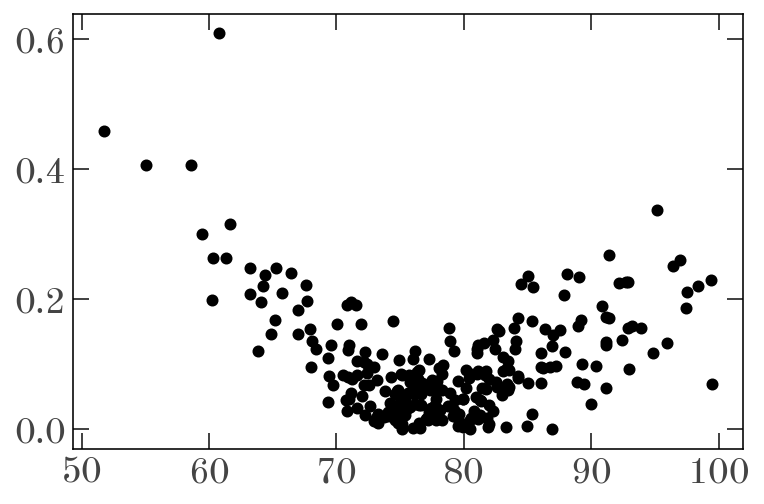

In [72]:
plt.scatter(samples['P'], samples['e'])

(-100.0, 5.0)

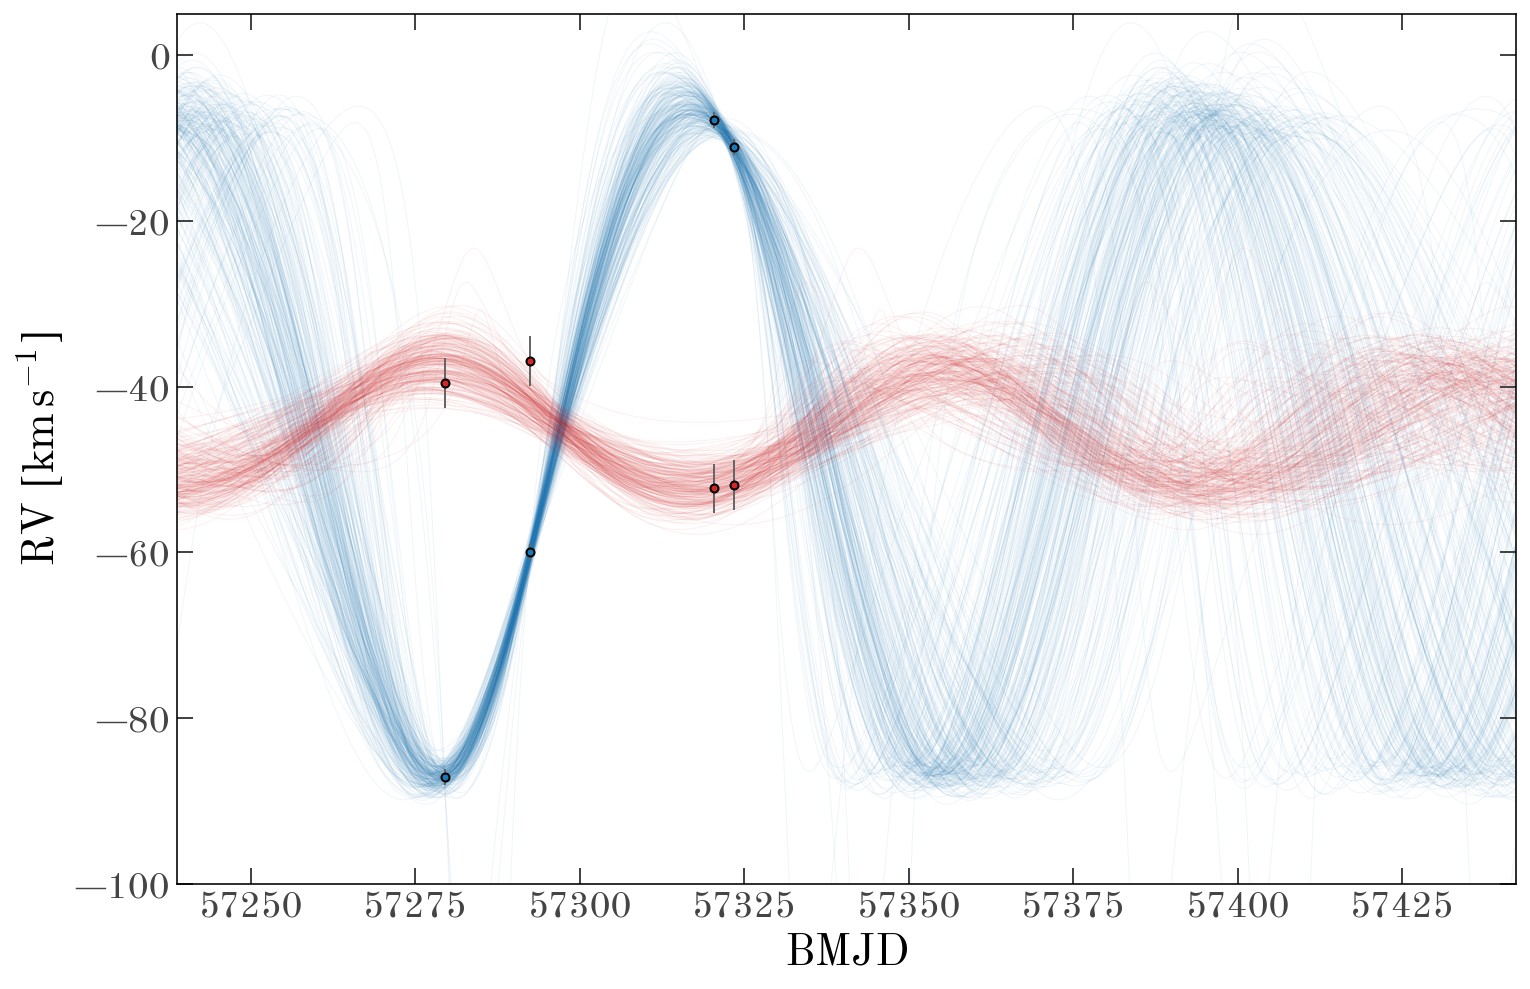

In [71]:
tgrid = datas['1'].t.min() + np.linspace(-0.5 * PP, 2 * PP, 4096) * u.day

fig, ax = plt.subplots(figsize=(12, 8))
_ = tj.plot_rv_curves(data=datas['1'], samples=samples.primary,
                      data_plot_kwargs=dict(color='tab:blue', zorder=100, mew=1, mec='k'),
                      plot_kwargs=dict(color='tab:blue', zorder=-100),
                      t_grid=tgrid, ax=ax)
# ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
# ax.set_ylim(-75, 75)

_ = tj.plot_rv_curves(data=datas['2'], samples=samples.secondary, 
                      data_plot_kwargs=dict(color='tab:red', zorder=100, mew=1, mec='k'),
                      plot_kwargs=dict(color='tab:red', zorder=-100),
                      t_grid=tgrid, ax=ax)

# ax.set_xlim(t0.mjd, t0.mjd + 5*truth1['P'].value)
ax.set_ylim(-100, 5)

In [62]:
K1 = np.abs(samples.primary['K'])
K2 = np.abs(samples.secondary['K'])
q = K2 / K1

Text(0.5, 0, '$q$')

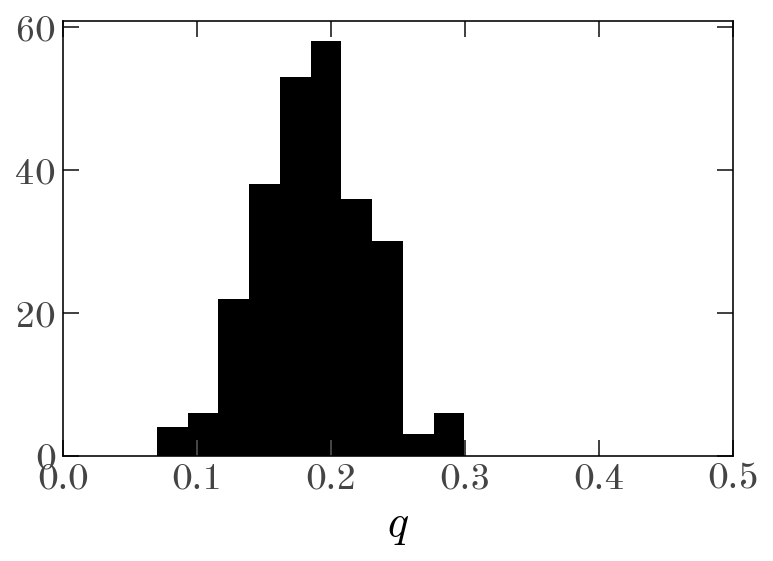

In [74]:
plt.hist(q.value)
plt.xlim(0, 0.5)
plt.xlabel('$q$')